In [6]:
import json
import pandas as pd

In [11]:
with open('sample.json', 'r') as file:
    in_json = json.load(file)

in_json

{'type': 'route',
 'route': {'id': 36534661,
  'highlighted_photo_id': 11658031,
  'highlighted_photo_checksum': 'd5ebb9cb1aaf00a0de22deb6c536d5b0',
  'distance': 59284.3,
  'elevation_gain': 708.797,
  'elevation_loss': 709.625,
  'track_id': '60d3de91fa348e269eb01ccf',
  'user_id': 604434,
  'pavement_type': None,
  'pavement_type_id': None,
  'recreation_type_ids': [],
  'visibility': 0,
  'created_at': '2021-06-23T18:23:29-07:00',
  'updated_at': '2022-09-28T12:26:59-07:00',
  'name': 'Camp Sherman Splendor: Family Overnighter',
  'description': 'Family bikepacking overnighter in an incredibly gorgeous place. Lots of camping options from multiple established campgrounds to dispersed camping. Variety of surfaces ranging from singletrack to red dirt to paved. Opportunities along the way to grab a bite at the Camp Sherman store, visit the fish hatchery, fly fish, or hike along the Metolius.',
  'first_lng': -121.65462,
  'first_lat': 44.45631,
  'last_lat': 44.45632,
  'last_lng': -12

In [68]:
df = pd.DataFrame(in_json['route']['track_points'])
df

,R,S,d,e,x,y,color,options
0,25,63,0.000,908.6,-121.65462,44.45631,NaN,NaN
1,25,63,3.340,908.6,-121.65462,44.45634,NaN,NaN
2,25,63,4.134,908.6,-121.65463,44.45634,16711680.0,90.0
3,25,63,51.681,909.0,-121.65520,44.45621,NaN,NaN
4,25,63,93.738,909.5,-121.65564,44.45600,NaN,NaN
...,...,...,...,...,...,...,...,...
946,4,0,59030.252,907.2,-121.65452,44.45860,NaN,NaN
947,4,0,59030.252,907.2,-121.65452,44.45860,NaN,NaN
948,4,0,59150.500,907.7,-121.65455,44.45752,NaN,NaN
949,4,0,59249.603,908.3,-121.65458,44.45663,NaN,NaN


# Step 1: calculate slope to next track_point for each track_point

I don't think this alone will work very well, because the distances between consecutive track_points are (1) variable and (2) small, but it's the first step toward a finished product.

In [22]:
deltas = df[['d', 'e']] - df[['d', 'e']].shift(1)
deltas['slope'] = deltas['e'] / deltas['d']
deltas

,d,e,slope
0,NaN,NaN,NaN
1,3.340,0.0,0.000000
2,0.794,0.0,0.000000
3,47.547,0.4,0.008413
4,42.057,0.5,0.011889
...,...,...,...
946,7.945,0.1,0.012587
947,0.000,0.0,NaN
948,120.248,0.5,0.004158
949,99.103,0.6,0.006054


<Axes: ylabel='Frequency'>

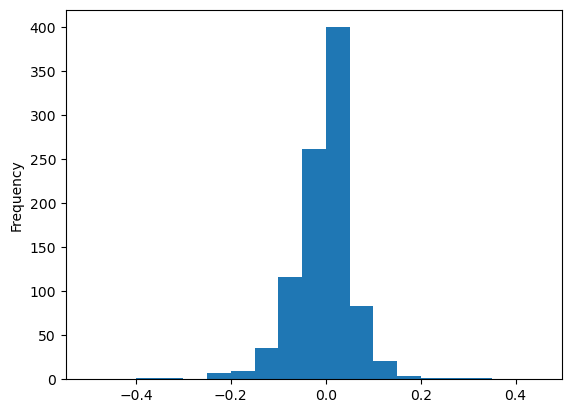

In [48]:
import numpy as np
deltas['slope'].plot.hist(bins=np.arange(-0.5, 0.5, 0.05))

## Encapsulation

We'll write one function that converts a DataFrame of track_points into a DataFrame of deltas with slope calculated, and another function that takes that DataFrame of deltas and visualizes it.

The first function includes an optional num_periods argument which controls how many rows to skip forward when calculating deltas. Fine-tuning this parameter will be important, especially once the rows are evenly spaced: we want to smooth out most of the micro-level noise from the elevation data, but still be sensitive to real short, steep slopes.

In [122]:
def points_to_deltas(df, num_periods=4, dist_col='d', elev_col='e'):
    deltas = df[[dist_col, elev_col]] - df[[dist_col, elev_col]].shift(num_periods)
    deltas['slope'] = deltas[elev_col] / deltas[dist_col]
    return deltas

In [123]:
def deltas_to_hist(deltas, min_slope=-0.25, max_slope=0.25, bin_width=0.01):
    bins = np.arange(min_slope, max_slope + 0.0001, bin_width)
    return deltas['slope'].clip(min_slope, max_slope).plot.hist(bins=bins)

# Step 2: resample/interpolate to regular intervals

What should the intervals be? 50 meters? 100 meters? It turns out that the number of rows to skip is actually more important. I think we're better off with quite short intervals (50 meters) so that we are quite frequently sampling the slope of the route, but that we want a fairly wide window for each sample (say, 200 meters) so as to smooth out noisy elevation data.

In [124]:
# Thanks to ChatGPT for most of the following code

def resample_by_distance(in_df, step=50, dist_col='d', elev_col='e'):
    # Make copy so as not to mutate the passed object
    df = in_df[[dist_col, elev_col]].copy()

    # First, drop duplicate distances
    df = df.drop_duplicates(dist_col)

    # Set the index to the distance column
    df = df.set_index(dist_col)

    # Create a new index with evenly spaced intervals
    new_index = pd.RangeIndex(start=round(df.index.min()), stop=round(df.index.max()), step=step)
    union_index = df.index.union(new_index)

    # Reindex the DataFrame using the new index
    df_reindexed = df.reindex(union_index)

    # Interpolate the missing elevation values
    df_interpolated = df_reindexed.interpolate(method='index')

    # Keep only the evenly spaced points
    df_interpolated = df_interpolated.loc[new_index]

    # Reset index to turn the distance back into a column
    df_interpolated.reset_index(inplace=True, names=dist_col)

    return df_interpolated

# Display the DataFrame
resample_by_distance(df)

,d,e
0,0.0,15.300000
1,50.0,15.300000
2,100.0,14.625920
3,150.0,13.345920
4,200.0,12.415298
...,...,...
4002,200100.0,27.135424
4003,200150.0,27.000000
4004,200200.0,26.832917
4005,200250.0,26.800000


## Test out the function

We'll compare the histograms with and without resampling.

<Axes: ylabel='Frequency'>

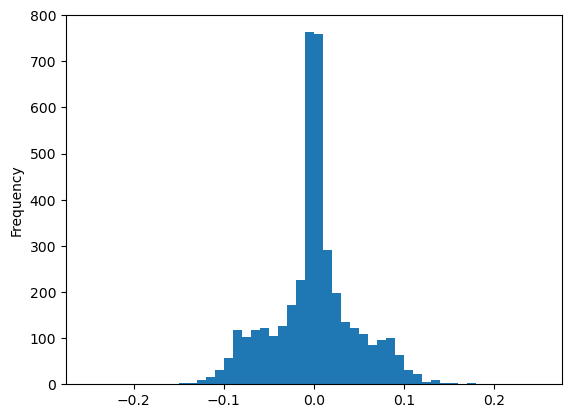

In [120]:
deltas_to_hist(points_to_deltas(resample_by_distance(df)))

<Axes: ylabel='Frequency'>

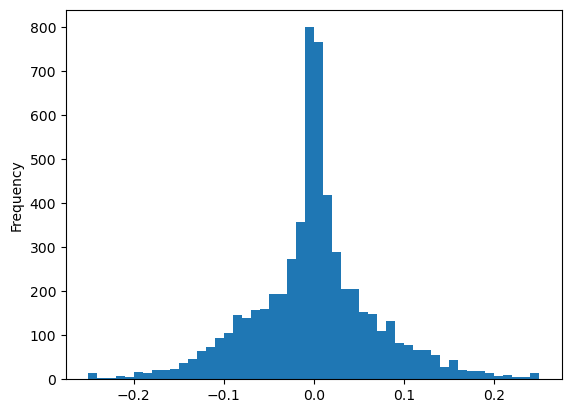

In [121]:
deltas_to_hist(points_to_deltas(df))

# Pull in actual data from RWGPS API

Get your own API key at https://ridewithgps.com/settings/developers

In [61]:
import requests

with open('rwgps_api_key.txt', 'r') as f:
    api_key = f.read().strip()

headers = {
  "apikey": api_key,
  "version": "2",
  "auth_token": ""
}


In [111]:
def get_route_df(route_id=36297826):
    url = f'https://ridewithgps.com/routes/{route_id}.json'
    r = requests.get(url, headers=headers)
    return pd.DataFrame(r.json()['track_points'])

In [140]:
def visualize_gradient_distribution(route_id=36297826, num_periods=3):
    df = get_route_df(route_id)
    df_resample = resample_by_distance(df)
    deltas = points_to_deltas(df, num_periods=num_periods)
    display(deltas_to_hist(deltas))
    plt.show()
    display(deltas.slope.plot.kde())
    # return deltas_to_hist(deltas)

<Axes: ylabel='Frequency'>

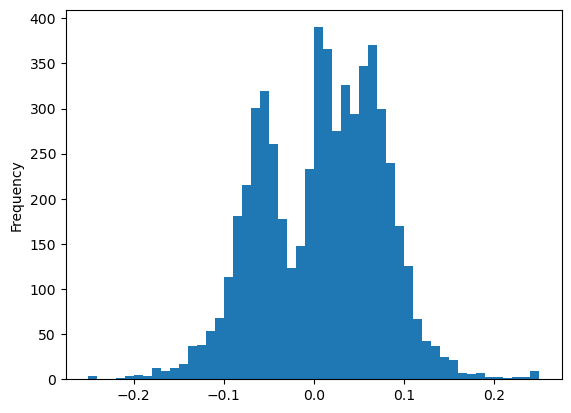

<Axes: ylabel='Density'>

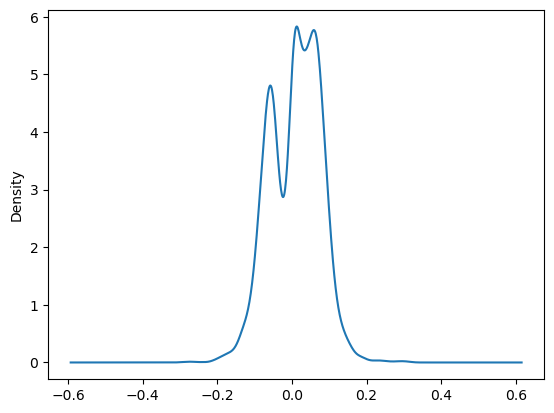

In [148]:
visualize_gradient_distribution(47490080, 20)

<Axes: ylabel='Frequency'>

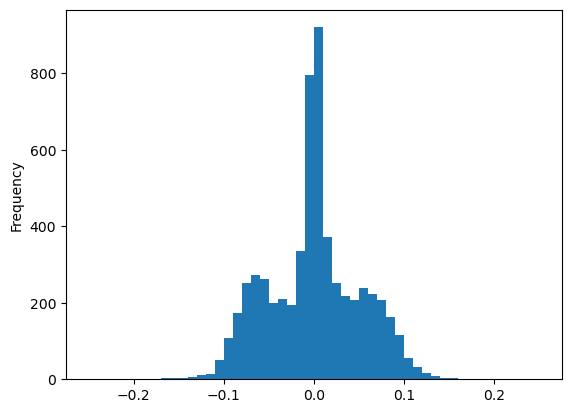

<Axes: ylabel='Density'>

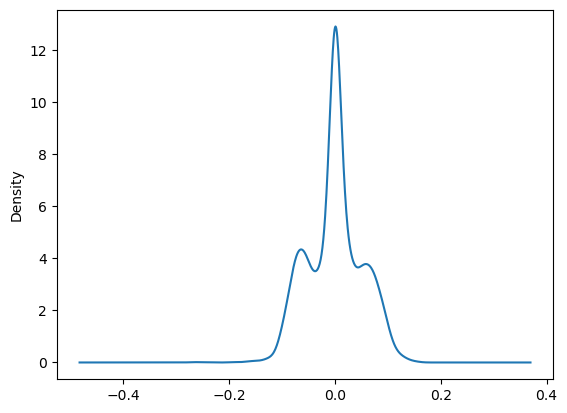

In [146]:
visualize_gradient_distribution(47094373, 10)

In [142]:
df = get_route_df(47094373)
df

,x,y,e,d,S,R,color,options
0,-122.298720,37.902750,15.3,0.0,3,28,NaN,NaN
1,-122.298745,37.902776,15.3,3.6,3,28,NaN,NaN
2,-122.298787,37.902820,15.3,9.7,3,28,NaN,NaN
3,-122.299100,37.903150,15.3,55.6,3,28,NaN,NaN
4,-122.299120,37.903190,15.2,60.4,3,28,NaN,NaN
...,...,...,...,...,...,...,...,...
5934,-122.055662,37.927785,26.8,200243.3,1,6,16711680.0,17.0
5935,-122.055660,37.927780,26.8,200243.8,1,6,NaN,NaN
5936,-122.055860,37.927630,26.8,200268.1,3,6,NaN,NaN
5937,-122.056330,37.927990,26.5,200325.6,3,21,NaN,NaN


In [143]:
df_resample = resample_by_distance(df)
df_resample

,d,e
0,0.0,15.300000
1,50.0,15.300000
2,100.0,14.625920
3,150.0,13.345920
4,200.0,12.415298
...,...,...
4002,200100.0,27.135424
4003,200150.0,27.000000
4004,200200.0,26.832917
4005,200250.0,26.800000


<Axes: ylabel='Density'>

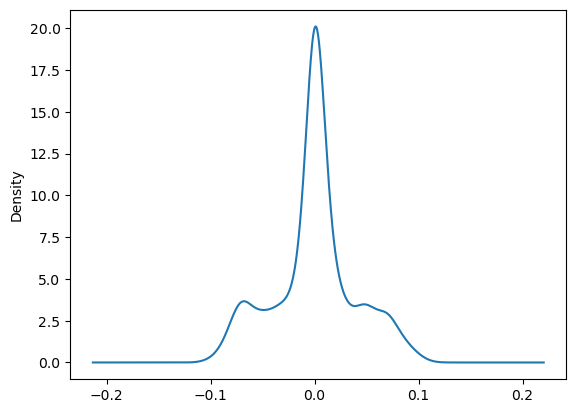

In [145]:
deltas.slope.plot.kde()

<Axes: >

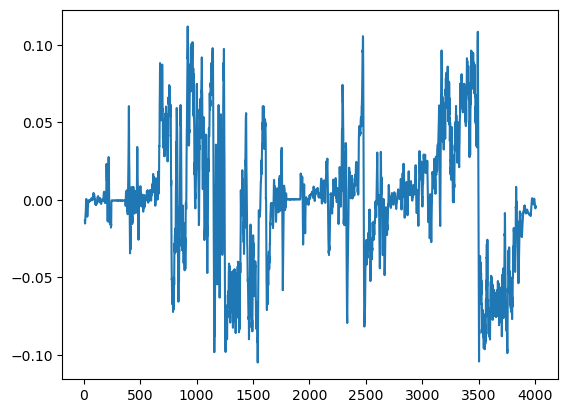

In [144]:
deltas = points_to_deltas(df_resample, num_periods=10)
deltas.slope.plot.line()

<Axes: >

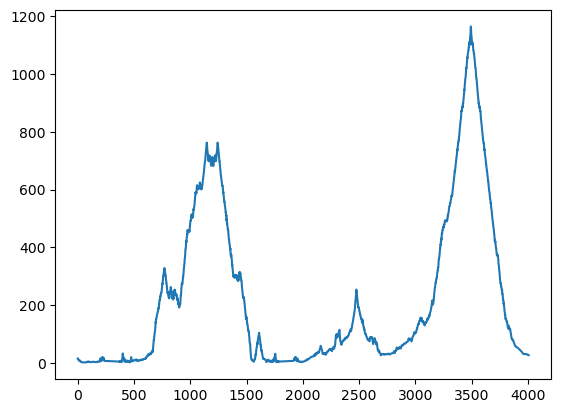

In [137]:
df_resample.e.plot.line()

<Axes: >

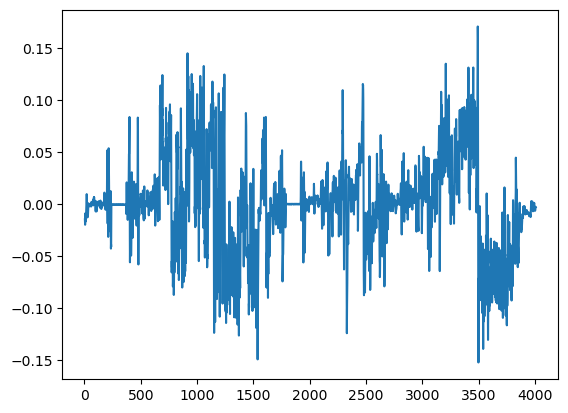